# Data analysis
Let's take a look at the relationships within our data.

In [2]:
# import necessary libraries and read our data
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

scaler = MinMaxScaler()
X = np.load('data/LSTM_EMA_diff_data.npy')
X_scaled = scaler.fit_transform(X)
columns = ['open', 'high', 'low', 'close', 'volume', 'EMA diff']
df = pd.DataFrame(X_scaled, columns=columns)
len(df) - 26

188076

In [3]:
c_mat = df.corr()
c_mat

,open,high,low,close,volume,EMA diff
open,1.000000,0.999992,0.999991,0.999986,-0.066526,0.001263
high,0.999992,1.000000,0.999985,0.999992,-0.065083,0.000839
low,0.999991,0.999985,1.000000,0.999992,-0.068300,0.001656
close,0.999986,0.999992,0.999992,1.000000,-0.066615,0.001211
volume,-0.066526,-0.065083,-0.068300,-0.066615,1.000000,-0.034575
EMA diff,0.001263,0.000839,0.001656,0.001211,-0.034575,1.000000


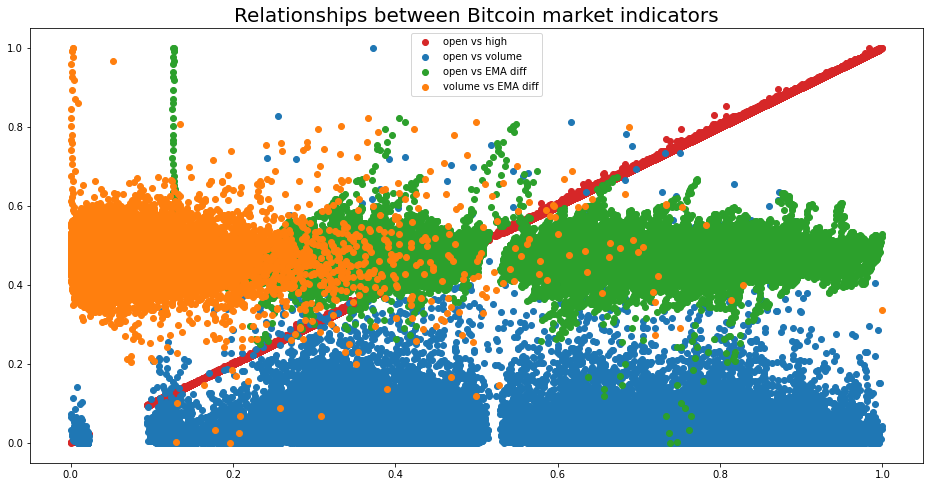

In [4]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.scatter(df['open'], df['high'], color='tab:red', label='open vs high')
ax.scatter(df['open'], df['volume'], color='tab:blue', label='open vs volume')
ax.scatter(df['open'], df['EMA diff'], color='tab:green', label='open vs EMA diff')
ax.scatter(df['volume'], df['EMA diff'], color='tab:orange', label='volume vs EMA diff')
ax.legend()
ax.set_title('Relationships between Bitcoin market indicators', fontsize=20)
plt.show()

Both our plot and our correlation matrix show that the price variables (open, high, low, and close prices) are higly correlated, while volume and EMA difference are weakly correlated with both each other and price. This suggests that it may be useful to perform dimension reduction on the data. First, we'll perform PCA to see if that gives us any useful information.

In [29]:
X = df.values
X.shape
pca = PCA(n_components=X.shape[1])
pca.fit(X)
ev = pca.explained_variance_ratio_
a = np.array([np.sum(ev[:i + 1]) for i in range(6)]) > 0.995
n_comps = X.shape[1] - (np.sum(a) - 1)

2

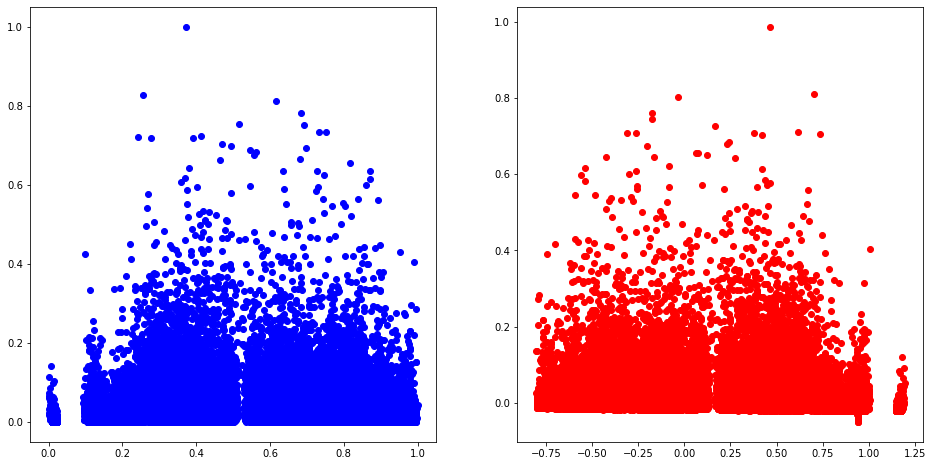

In [33]:
X = df.values
pca = PCA(n_components=n_comps)
principal_comps = pca.fit_transform(X)

df_reduced = pd.DataFrame(principal_comps, columns=['pc1', 'pc2'])

# plot
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

axes[0].scatter(df['open'], df['volume'], color='blue', label='raw price vs volume')
axes[1].scatter(df_reduced['pc1'], df_reduced['pc2'], color='red', label='PCA')
ax.legend()
plt.show()

Visually, the PCA data seems to have a very similar structure to the raw price vs volume data. This suggests that performing PCA doesn't add very much to our understanding of the data, and might not be that useful to our model. PCA also tends to obfuscate the model's actual function, since instead of price, volume, and market cap labels, we just have various principal components. For this reason, it may be worthwhile to simply drop the highly correlated columns from our data.

## Balance of dataset
Another important metric is how balanced our data is. If there are significantly more of one type of label, we'll need to use a different metric for our models' performances. We're labeling by whether price increases or decreases; an easy expedient for this is to use Numpy to find the differences between subsequent points, and then use the signs of each entry in the resulting difference array as labels (labeling the last point 'hold' for now).

In [12]:
prices = np.array(df['prices'])
diffs = np.diff(prices)
labels = np.append(np.sign(diffs), 0)
pos_labels = np.sum(labels == 1)
neg_labels = np.sum(labels == -1)
z_labels = 1
n = len(labels)
print(f'Data proportions: Buy: {pos_labels / n}; Sell: {neg_labels / n}; Hold: {z_labels / n}')

Data proportions: Buy: 0.4909847434119279; Sell: 0.507628294036061; Hold: 0.0013869625520110957


The label split is almost 50-50; 49% of the data are in the 'buy' class, and 51% are in the 'sell' class. The added 'hold' label at the end is negligible for now. This means accuracy using simple MCE is a decent metric for our models' performances.  
Notably, this gives us some leeway. If we wanted to train more conservative models that traded more cautiously, we could use precision as a metric, which would tend to favor models that made fewer false-positive errors.

In [9]:
# rebalance
scaler = MinMaxScaler()
data = np.load('data/LSTM_EMA_diff_data.npy')
data = scaler.fit_transform(data)

avg_window = 10 # can't be longer than sequence length
windowed_size = len(data) - avg_window
avgs = np.zeros(windowed_size)
labels = [0]*windowed_size
for i in range(windowed_size):
    avgs[i] = np.average(data[i:i + avg_window, 0])
    labels[i] = int(np.sign(avgs[i] - data[i, 0]))
    if(labels[i] < 0): labels[i] = 0

seq_len = 60
batch_len = len(data) - seq_len
n_features = 6
X_batched = np.zeros((batch_len, seq_len, n_features))
for i in range(batch_len):
    X_batched[i] = data[i:i + seq_len]
labels = labels[:batch_len]
print(np.sum(labels), len(labels))

94405 188042


In [10]:
print(np.sum(labels) / len(labels))

0.5020420969783346
